### Import Libraries and Read Data

In [1]:
## Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
pd.plotting.register_matplotlib_converters()
plt.style.use('seaborn-dark')

In [3]:
download_link = 'https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data'
# see https://www.arcgis.com/home/item.html?id=dd4580c810204019a7b8eb3e0b329dd6

In [4]:
## Read Data for Cases, Deaths and Recoveries
rki_raw = pd.read_csv(download_link)

In [5]:
rki_raw.tail()

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen
91466,14,Sachsen,LK Meißen,A05-A14,M,1,0,1932404,2020-04-01T00:00:00.000Z,14627,"13.04.2020, 00:00 Uhr",0,-9,2020-03-29T00:00:00.000Z,0,1
91467,14,Sachsen,LK Meißen,A05-A14,W,1,0,1932405,2020-03-10T00:00:00.000Z,14627,"13.04.2020, 00:00 Uhr",0,-9,2020-03-06T00:00:00.000Z,0,1
91468,14,Sachsen,LK Meißen,A15-A34,M,1,0,1932406,2020-03-24T00:00:00.000Z,14627,"13.04.2020, 00:00 Uhr",0,-9,2020-03-16T00:00:00.000Z,0,1
91469,14,Sachsen,LK Meißen,A15-A34,M,1,0,1932407,2020-03-24T00:00:00.000Z,14627,"13.04.2020, 00:00 Uhr",0,-9,2020-03-17T00:00:00.000Z,0,1
91470,14,Sachsen,LK Meißen,A15-A34,M,1,0,1932408,2020-03-26T00:00:00.000Z,14627,"13.04.2020, 00:00 Uhr",0,-9,2020-03-18T00:00:00.000Z,-9,0


In [6]:
def new_cases_by_date(rki_raw, rki_flag_column='NeuerFall', rki_count_columns='AnzahlFall'):
    """
    rki_raw: raw DataFrame from Robert Koch Institute
    """
    condition = rki_raw[rki_flag_column].isin((0, 1))
    rki_series = rki_raw[condition].groupby('Meldedatum').sum()[rki_count_columns].copy()
    rki_series.index = pd.to_datetime(rki_series.index)
    rki_series.sort_index(inplace=True)
    return rki_series

In [7]:
rki_cases = new_cases_by_date(rki_raw)
rki_death = new_cases_by_date(rki_raw, rki_flag_column='NeuerTodesfall', rki_count_columns='AnzahlTodesfall')
rki_recovered = new_cases_by_date(rki_raw, rki_flag_column='NeuGenesen', rki_count_columns='AnzahlGenesen')

In [8]:
rki = pd.concat([rki_cases, rki_death, rki_recovered], axis=1, sort=True)
columns_dict = {'AnzahlFall': 'NewCases', 'AnzahlTodesfall': 'NewDeath', 'AnzahlGenesen': 'NewRecovered'}
rki.rename(columns_dict, axis=1, inplace=True)
rki.fillna(value=0., inplace=True)
rki.tail()

,NewCases,NewDeath,NewRecovered
Meldedatum,,,
2020-04-08 00:00:00+00:00,5151,61.0,554.0
2020-04-09 00:00:00+00:00,4656,44.0,368.0
2020-04-10 00:00:00+00:00,2984,19.0,135.0
2020-04-11 00:00:00+00:00,2134,11.0,76.0
2020-04-12 00:00:00+00:00,533,2.0,13.0


In [9]:
rki['Cases'] = rki['NewCases'].cumsum()
rki['Death'] = rki['NewDeath'].cumsum()
rki['Recovered'] = rki['NewRecovered'].cumsum()
rki['ActiveCases'] = rki['Cases'] - rki['Recovered']
rki['Growth'] = rki['NewCases'] / rki['ActiveCases']
rki.tail(10)

,NewCases,NewDeath,NewRecovered,Cases,Death,Recovered,ActiveCases,Growth
Meldedatum,,,,,,,,
2020-04-03 00:00:00+00:00,6236,145.0,1882.0,92128,2346.0,59951.0,32177.0,0.193803
2020-04-04 00:00:00+00:00,4221,76.0,1079.0,96349,2422.0,61030.0,35319.0,0.119511
2020-04-05 00:00:00+00:00,2506,64.0,542.0,98855,2486.0,61572.0,37283.0,0.067216
2020-04-06 00:00:00+00:00,3640,97.0,755.0,102495,2583.0,62327.0,40168.0,0.090619
2020-04-07 00:00:00+00:00,5063,79.0,791.0,107558,2662.0,63118.0,44440.0,0.113929
2020-04-08 00:00:00+00:00,5151,61.0,554.0,112709,2723.0,63672.0,49037.0,0.105043
2020-04-09 00:00:00+00:00,4656,44.0,368.0,117365,2767.0,64040.0,53325.0,0.087314
2020-04-10 00:00:00+00:00,2984,19.0,135.0,120349,2786.0,64175.0,56174.0,0.053121
2020-04-11 00:00:00+00:00,2134,11.0,76.0,122483,2797.0,64251.0,58232.0,0.036647


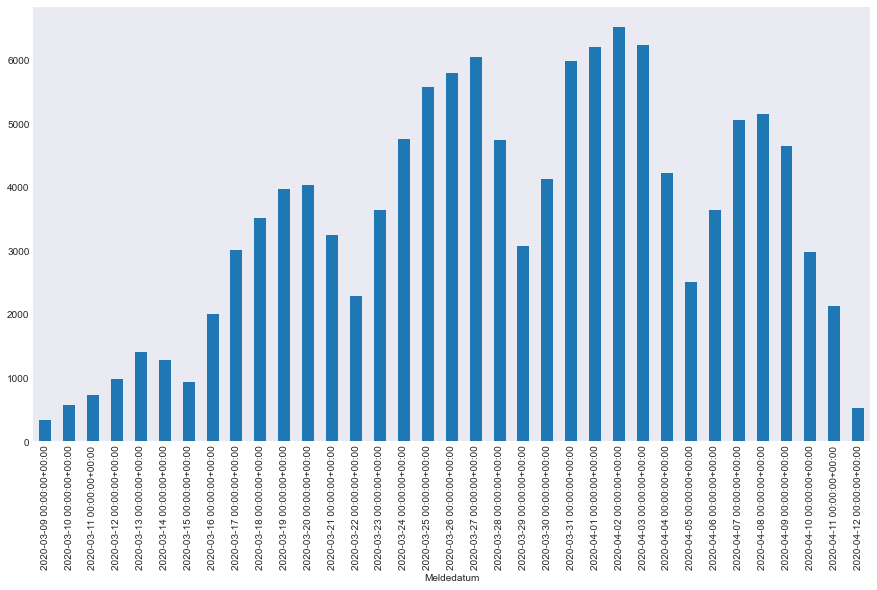

In [10]:
rki.NewCases['03-09-2020':].plot.bar()

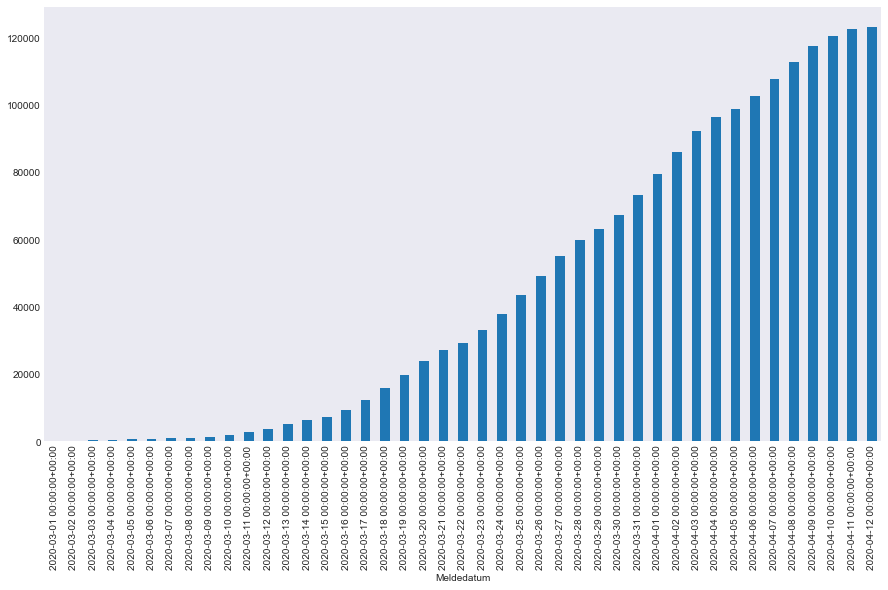

In [11]:
rki.Cases['03-01-2020':].plot.bar()

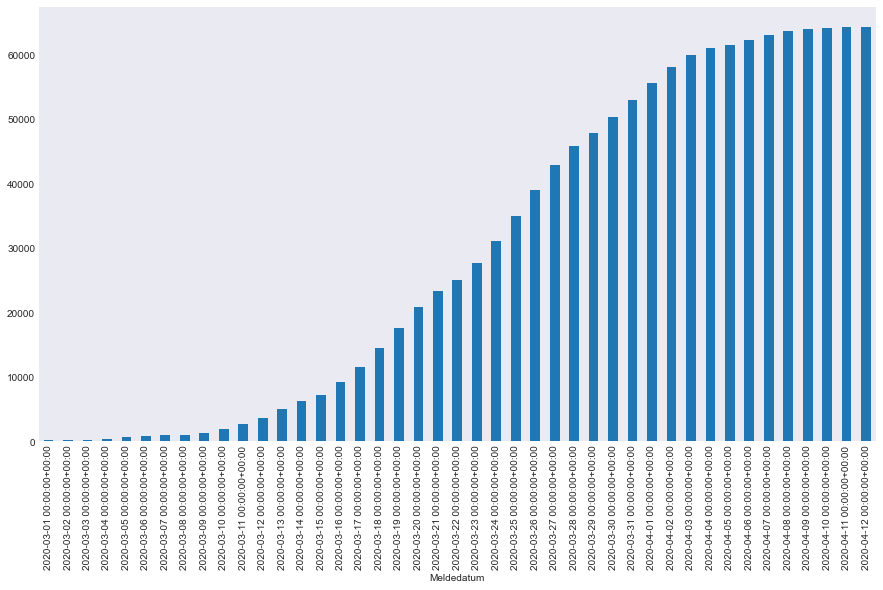

In [12]:
rki.Recovered['03-01-2020':].plot.bar()

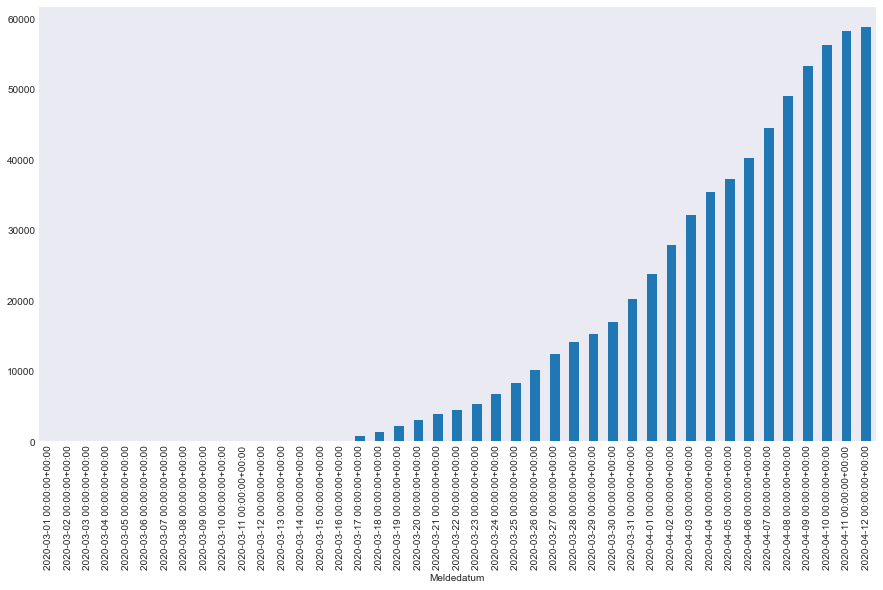

In [13]:
rki.ActiveCases['03-01-2020':].plot.bar()

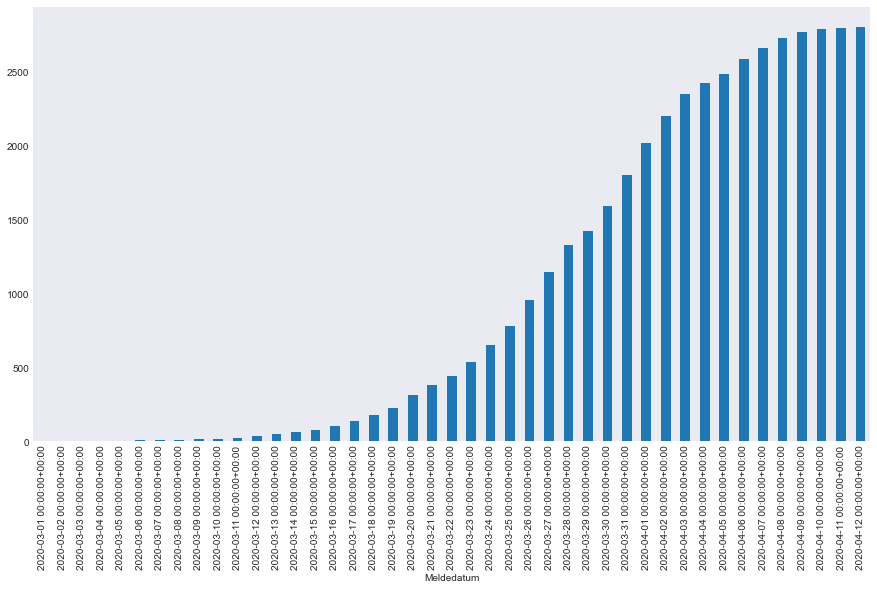

In [14]:
rki.Death['03-01-2020':].plot.bar()

Text(0.5, 1.0, 'Growth Germany')

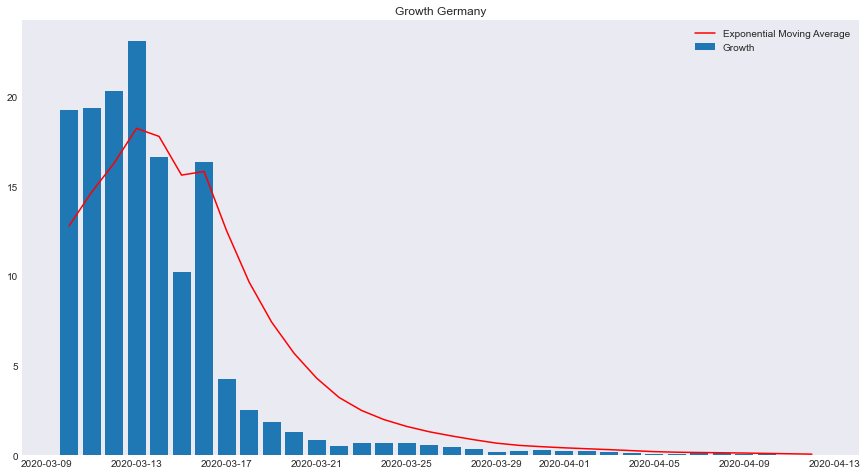

In [15]:
start_date = '03-10-2020'
x = rki[start_date:].index

plt.bar(x, rki.Growth[start_date:], label='Growth')
plt.plot(x, rki.Growth.ewm(span=6,adjust=False).mean()[start_date:], label='Exponential Moving Average', color='red')
plt.legend(loc='best')
plt.title('Growth Germany')

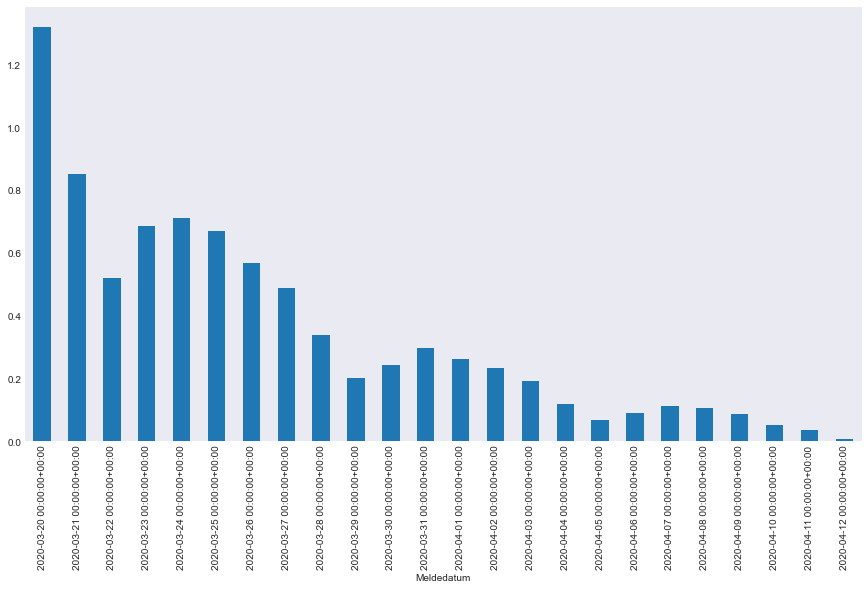

In [16]:
rki.Growth['03-20-2020':].plot.bar()

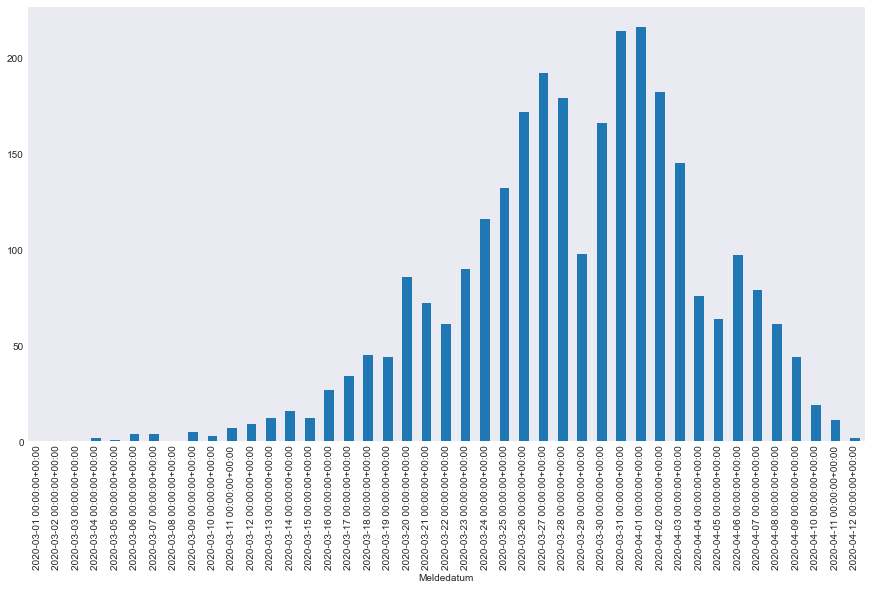

In [17]:
rki.NewDeath['03-01-2020':].plot.bar()

Text(0.5, 1.0, 'New Cases Germany')

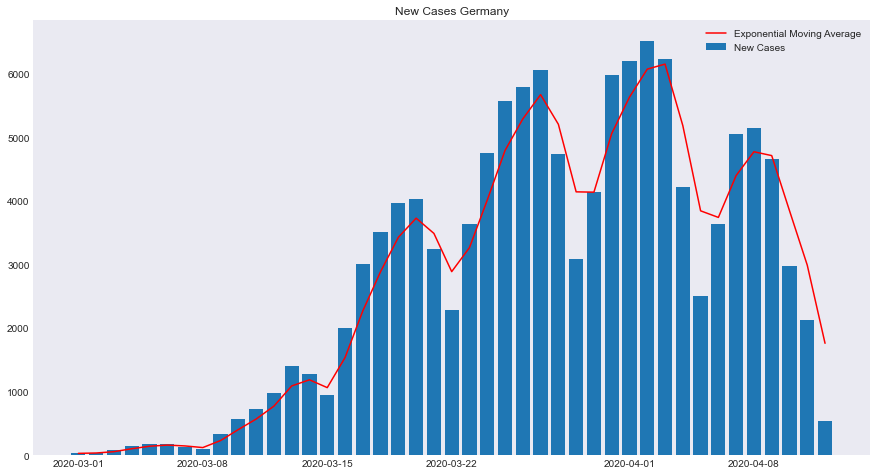

In [18]:
start_date = '03-01-2020'
x = rki[start_date:].index

plt.bar(x, rki.NewCases[start_date:], label='New Cases')
plt.plot(x, rki.NewCases.ewm(span=3,adjust=False).mean()[start_date:], label='Exponential Moving Average', color='red')
plt.legend(loc='best')
plt.title('New Cases Germany')

In [19]:
rki.tail(20)

,NewCases,NewDeath,NewRecovered,Cases,Death,Recovered,ActiveCases,Growth
Meldedatum,,,,,,,,
2020-03-24 00:00:00+00:00,4765,116.0,3386.0,37790,650.0,31095.0,6695.0,0.711725
2020-03-25 00:00:00+00:00,5577,132.0,3944.0,43367,782.0,35039.0,8328.0,0.669669
2020-03-26 00:00:00+00:00,5792,172.0,3941.0,49159,954.0,38980.0,10179.0,0.569015
2020-03-27 00:00:00+00:00,6057,192.0,3867.0,55216,1146.0,42847.0,12369.0,0.489692
2020-03-28 00:00:00+00:00,4743,179.0,3056.0,59959,1325.0,45903.0,14056.0,0.337436
2020-03-29 00:00:00+00:00,3083,98.0,1907.0,63042,1423.0,47810.0,15232.0,0.202403
2020-03-30 00:00:00+00:00,4136,166.0,2489.0,67178,1589.0,50299.0,16879.0,0.245038
2020-03-31 00:00:00+00:00,5987,214.0,2696.0,73165,1803.0,52995.0,20170.0,0.296827
2020-04-01 00:00:00+00:00,6209,216.0,2628.0,79374,2019.0,55623.0,23751.0,0.261421
